In [55]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import norm, chi2_contingency, shapiro, mannwhitneyu
import statsmodels.stats.api as sms
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import os
import os.path

plt.style.use('ggplot')

In [56]:
#  файл с информацией о принадлежности пользователя к контрольной
#  или экспериментальной группе (А – контроль, B – целевая группа)

groups = pd.read_csv("Проект_2_groups.csv", sep=";")

# файл с информацией о пользователях, которые зашли 
# на платформу в дни проведения эксперимента.

active_studs = pd.read_csv("Проект_2_active_studs.csv").rename(columns={'student_id': 'id'})
#добавляем доп.колонку active со значением "1"
active_studs['active'] = 1

# файл с информацией об оплатах пользователей в дни проведения эксперимента.
#переименоваем столбец
checks = pd.read_csv("Проект_2_checks.csv", sep=";").rename(columns={'student_id': 'id'})

# дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

group_add = pd.read_csv('Проект_2_group_add.csv')

# Условие задачи

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

**Т.к. мы предлагаем новый механизм оплаты услуг на сайте, проверим на сколько значимо изменилось кол-во оплат у тестовой группы по сравнению с контрольной.**


# Подготовка и анализ данных

In [57]:
#сойденяем таблицы groups + group_add
data = pd.concat([groups,group_add],axis=0)

In [58]:
#проверка кол-во строк до
data.shape

(74576, 2)

In [5]:
#Объединение данных и замена Nan на "0"
df = data.merge(checks, how='left').merge(active_studs, how='left').merge(group_add, how='left').fillna(0)
#добавление столбца с кол-во оплат.
df['qty_pay'] = df['rev'].apply(lambda x: 1 if x>0 else 0)
df.head()

,id,grp,rev,active,qty_pay
0,1489,B,0.0,0.0,0
1,1627,A,990.0,1.0,1
2,1768,B,0.0,0.0,0
3,1783,B,0.0,0.0,0
4,1794,A,0.0,0.0,0


In [6]:
#кол-во строк после объединение 
df.shape

(74576, 5)

In [7]:
#проверка типа данных
df.dtypes

id           int64
grp         object
rev        float64
active     float64
qty_pay      int64
dtype: object

In [8]:
#
df.groupby('grp').agg({'id': 'count'})

,id
grp,
A,14693
B,59883


In [9]:
df.groupby(['active', 'grp'], as_index=False).agg({'id': 'count', 'qty_pay': 'mean', 'rev': lambda x: np.mean(x)})

,active,grp,id,qty_pay,rev
0,0.0,A,13155,0.002204,1.465298
1,0.0,B,53080,0.002261,1.625019
2,1.0,A,1538,0.050715,47.347204
3,1.0,B,6803,0.046156,58.058798


**Есть часть клиентов, которые оплатили не в день проведения эксперимента, их мы исключаем из данных.**

In [10]:
#Разделяем на две группы control и test
df_control = df[(df['grp']=='A')&(df['active'] == 1)][['grp', 'qty_pay']]
df_control.reset_index(inplace=True, drop = True)

In [11]:
df_test = df[(df['grp']=='B')&(df['active'] == 1)][['grp', 'qty_pay']]
df_test.reset_index(inplace=True, drop = True)

In [12]:
df_control.describe().T

,count,mean,std,min,25%,50%,75%,max
qty_pay,1538.0,0.050715,0.219487,0.0,0.0,0.0,0.0,1.0


In [13]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
qty_pay,6803.0,0.046156,0.209838,0.0,0.0,0.0,0.0,1.0


В контрольном и тестовом наборе данных посчитаем соотношение тех
кто совершил покупку, по сравнению со всеми, кто заходит на сайт в день проведения эксперемента

In [14]:
control_sum_qty = df_control['qty_pay'].sum()
print("Контрольная группа")
print("Кол-во покупок: ", control_sum_qty)
control_visit = df_control['qty_pay'].count()
print("Кол-во поситителей: ", control_visit)

Контрольная группа
Кол-во покупок:  78
Кол-во поситителей:  1538


In [15]:
control_ratio = control_sum_qty/control_visit
control_ratio

0.05071521456436931

In [16]:
test_sum_qty = df_test['qty_pay'].sum()
print("Тестовая группа")
print("Кол-во покупок: ", test_sum_qty)
test_visit = df_test['qty_pay'].count()
print("Кол-во поситителей: ", test_visit)

Тестовая группа
Кол-во покупок:  314
Кол-во поситителей:  6803


In [17]:
test_ratio = test_sum_qty/test_visit
test_ratio

0.046156107599588415

Когда мы смотрим на конверсию в покупках, мы видим, что между двумя группами есть разница. 
Кажется, что новая механика оплаты услуг на сайте, примененная к тестовой группе, получает меньше покупок. 
Но этот результат может ввести в заблуждение. Поэтому следует искать ответ на вопрос, есть ли статистически значимая разница. 
Теперь проведем A/B-тестирование.

Для применения A/B-тестирования набор данных должен удовлетворять предположениям об однородности нормальности и дисперсии.
Затем можно перейти к реализации проверки гипотез.

Если обеспечивается однородность нормальности и дисперсии, 
применяется независимый двухвыборочный t-критерий (параметрический критерий).
Если нормальность и однородность дисперсии не обеспечиваются, 
выполняется U-критерий Манна-Уитни (непараметрический критерий). 
Как проверить предположение о нормальности? При этом мы сначала определим гипотезы H0 и H1.

**H0 : Предполагается нормальность.**

**H1 : Предположение о нормальности не предусмотрено.**
    
Теперь проверим предположение о нормальности.

# Двухвыборочный t-критерий

In [18]:
test_stat, pvalue = shapiro(df_control['qty_pay'])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 0.2259, p-value = 0.0000


In [19]:
test_stat, pvalue = shapiro(df_test['qty_pay'])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 0.2125, p-value = 0.0000


/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


**H0 отклоняется, поскольку значение p <0,05. Предположение о нормальности не было обеспечено.**

Поэтому воспользуемся U-критерием Манна-Уитни.

**H0 : Между двумя группами нет существенной разницы в отношении новой механика оплаты услуг на сайте.**

**Н1: Есть разница.**

# Mann-Whitney U Test

In [20]:
test_stat, pvalue = mannwhitneyu(df_control["qty_pay"],
                                 df_test["qty_pay"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 5255358.0000, p-value = 0.4455


H0 не отклоняется, поскольку значение p>0,05.
Другими словами, мы можем статистически сказать, что между двумя группами нет различия.

In [21]:
group_count = df.query('active == 1').groupby(['grp', 'qty_pay'])['grp'].count().reset_index(name='Count')
groupped = pd.crosstab(group_count['grp']\
                       , group_count['qty_pay']\
                       , values=group_count['Count']\
                       , aggfunc=np.sum, margins=True)

In [22]:
100*groupped.div(groupped['All'], axis=0)

qty_pay,0,1,All
grp,,,
A,94.928479,5.071521,100.0
B,95.384389,4.615611,100.0
All,95.300324,4.699676,100.0


**Вывод**

Уровень конверсии в контрольной группе 5.07%, в тестовой показатель уменьшился до 4.6%. По результату наших тестов можно 
сказать, что уровень изменения конверсии незначителен, что потверждается статистикой.

**Не стоит запускать новую механику на всех пользователей!**

# ПРОВЕРИМ СТАТИСТИЧЕСКУЮ ГИПОТЕЗУ BOOTSTRAP

**H0 : Между двумя группами нет существенной разницы в отношении новой механики оплаты услуг на сайте.**

**Н1: Есть разница.**

In [23]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

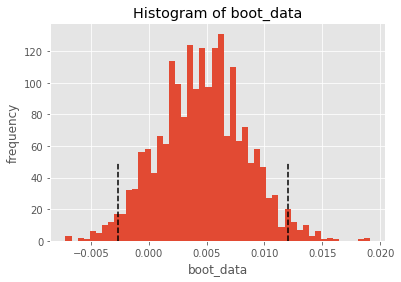

In [24]:
booted_data = get_bootstrap(df_control["qty_pay"], df_test["qty_pay"], boot_it = 2000) # в результате хранится разница двух распределений, ДИ и pvalue

In [25]:
booted_data["p_value"]

print('p-value = %.4f' % (booted_data["p_value"]))

p-value = 0.2162


In [26]:
booted_data["ci"]

,0
0.025,-0.002646
0.975,0.012054


**Вывод**

p-value > 0,05 не отклоняем Н0 гипотезу. Боотстрап подтверждает предыдущие выводы.

**Не стоит запускать новую механику на всех пользователей!**

# Проверим гипотезу ещё одним методом хи-квадрат.

Н0 - доли равни
Н1 - доли не равны

In [27]:
#Построим таблицу сопряжености
contingency_table = df.query('active == 1').groupby('grp').agg({'qty_pay': sum, 'active': sum})

In [28]:
res = chi2_contingency(contingency_table)
print('p-value = %.4f' % (res[1]))

p-value = 0.5090


**Вывод**

p-value получается > 0,05, поэтому основание отвергнуть гипотезу о равенстве долей нет.

# Задание 2. SQL

**Задание 2. SQL**

2.1 Очень усердные ученики.

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин за час.

In [29]:
'''SELECT DISTINCT st_id
FROM
  (SELECT st_id,
          sum(correct) OVER w AS res_sum
   FROM peas WINDOW w AS (PARTITION BY st_id
                          ORDER BY timest ASC RANGE BETWEEN '1 hour' PRECEDING AND '1 hour' FOLLOWING)
   ORDER BY st_id ASC) AS a
   
WHERE res_sum >= 20'''
''''''

''

2.1.2 Задача

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов за март 2020 года.

NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [30]:
'''SELECT st_id, sum(correct)
FROM peas
where timest between '2020-03-01' and '2022-03-31'
group by st_id
having sum(correct) > 20'''
''''''

''

**2.2 Оптимизация воронки**

2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

ARPU 

ARPAU 

CR в покупку 

СR активного пользователя в покупку 

CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

In [31]:
'''SELECT CAST("Доход" AS float) / CAST("Активный пользователей" AS float) AS ARPAU,
      CAST("Доход" AS float) / CAST("Число пользователей" AS float) AS ARPU,
      CAST("Число клиентов" AS float) / CAST("Число пользователей" AS float) as CR,
      CAST("Число клиентов" AS float) / CAST("Активный пользователей" AS float) as "cr актив. пользов.",
      CAST("Число покупок math" AS float) / CAST("Актив пользов по math" AS float) as CR_math
FROM
  (SELECT test_grp,
          COUNT(DISTINCT st_id) filter(
                                       WHERE MONEY > 0) AS "Число клиентов",
          COUNT(MONEY) AS "Число покупок",
          sum(MONEY) AS "Доход",
          COUNT(DISTINCT st_id) AS "Число пользователей",
          COUNT(DISTINCT st_id) filter(
                                       WHERE sum_correct > 0) AS "Активный пользователей",
          COUNT(DISTINCT st_id) filter(
                                       WHERE subject = 'math'
                                         AND sum_correct > 0) AS "Актив пользов по math",
          COUNT(MONEY) filter(
                              WHERE subject = 'math'
                                AND sum_correct > 0) AS "Число покупок math"
   FROM
     (SELECT D.st_id,
             D.subject,
             D.sum_correct,
             D.test_grp,
             C.money
      FROM
        (SELECT A.id,
                A.st_id,
                A.subject,
                A.sum_correct,
                B.test_grp
         FROM
           (SELECT st_id,
                   subject,
                   concat(st_id, subject) AS id,
                   sum(correct) AS sum_correct
            FROM peas
            GROUP BY st_id,
                     subject,
                     id) AS A
         LEFT JOIN studs AS B ON A.st_id = B.st_id) AS D
      LEFT JOIN
        (SELECT MONEY,
                concat(st_id, subject) AS id
         FROM checks) AS C ON D.id = C.id) AS J
   GROUP BY test_grp) AS H'''

''''''

data = pd.read_csv('task-2_2_2.csv')
data

,arpau,arpu,cr,cr актив. пользов.,cr_math
0,98.166667,98.166667,0.333333,0.333333,0.166667
1,208.750000,208.750000,0.750000,0.750000,0.500000


# Задание 3. Python

**3.1 Задача**

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [1]:
#Проверяет еcть ли файл "Проект_2_group_add.csv" в папке. Функция для автоматическоЙ загрузки файла.
def add_data(name):
    file_name = name #file to be searched
    cur_dir = os.getcwd() # Dir from where search starts can be replaced with any pathwhile True:
    file_list = os.listdir(cur_dir)
    parent_dir = os.path.dirname(cur_dir)
    if file_name in file_list:
        print("File Exists in: ", cur_dir)
        #  файл с информацией о принадлежности пользователя к контрольной 
        #  или экспериментальной группе (А – контроль, B – целевая группа) 
        groups = pd.read_csv("Проект_2_groups.csv", sep=";")
        # дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
        group_add = pd.read_csv(name)
        return pd.concat([groups,group_add],axis=0)
    else:
        return pd.read_csv("Проект_2_groups.csv", sep=";")
    
        

In [53]:
data = add_data('Проект_2_group_add.csv')

File Exists in:  /mnt/HC_Volume_18315164/home-jupyter/jupyter-r-mangursuzjan-18/final_project


In [60]:
#Объединение данных и замена Nan на "0"
df = data.merge(checks, how='left').merge(active_studs, how='left').merge(group_add, how='left').fillna(0)
#добавление столбца с кол-во оплат.
df['qty_pay'] = df['rev'].apply(lambda x: 1 if x>0 else 0)
df.head()

#Разделяем на две группы control и test
df_control = df[(df['grp']=='A')&(df['active'] == 1)][['grp', 'qty_pay']]
df_control.reset_index(inplace=True, drop = True)
df_test = df[(df['grp']=='B')&(df['active'] == 1)][['grp', 'qty_pay']]
df_test.reset_index(inplace=True, drop = True)


# ПРОВЕРИМ СТАТИСТИЧЕСКУЮ ГИПОТЕЗУ BOOTSTRAP

**H0 : Между двумя группами нет существенной разницы в отношении новой механики оплаты услуг на сайте.**

**Н1: Есть разница.**

In [61]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

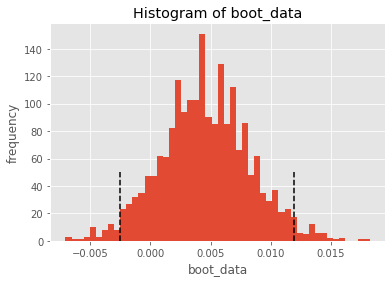

In [62]:
booted_data = get_bootstrap(df_control["qty_pay"], df_test["qty_pay"], boot_it = 2000) # в результате хранится разница двух распределений, ДИ и pvalue

In [63]:
booted_data["p_value"]

print('p-value = %.4f' % (booted_data["p_value"]))

p-value = 0.2125


In [64]:
booted_data["ci"]

,0
0.025,-0.002499
0.975,0.011907


**Вывод**

p-value > 0,05 не отклоняем Н0 гипотезу. Боотстрап подтверждает предыдущие выводы.

**Не стоит запускать новую механику на всех пользователей!**